In [1]:
import pandas as pd
import os

In [2]:
from glob import glob 
ls = glob("SensorData2/*")
ls = sorted(ls)

In [90]:
folder = "SensorData2"

In [91]:
def create_dr(df):
    minn = df.index.values.min()
    maxx = df.index.values.max()
    date_range =pd.date_range(start=minn, end=maxx, freq='ms')

    return date_range

In [92]:
from IPython.display import clear_output
import traceback
for ff in  glob(f"{folder}/*"):
    print ("Processing Folder", ff)
    z = iter(range(25))
    set_dt = False
    for csv in glob(f"{ff}/[!f]*.csv"):
        # try:
        sensor = csv.split("@")[0].split("/")[-1]
        df = pd.read_csv(csv, header=0, names=['date','time','val'])
        df['date'] =  df['date'] + " " + df['time']
        df = df.drop(labels = ['time'], axis = 1)
        df['date'] = pd.to_datetime( df['date'] )
        df.rename(columns={'val':sensor}, inplace=True)
        df = df.set_index(keys=['date'])
        # print ("------------",df.columns)
        if not set_dt:
            date_range = create_dr(df)
            final = pd.DataFrame(date_range, columns = ['date'])
            set_dt = True
        
        final = pd.merge_asof(final, df, on='date')
    
    final = final.reindex(sorted(final.columns), axis=1)
    final.set_index(keys=['date'], inplace=True)
    final.to_parquet(f"{ff}/final.parquet")
    print ("Saved------"*2,final.shape )

Processing Folder SensorData2/E12-IoTool sensor data_ 2022-08-31-13-51-22
Saved------Saved------ (325391, 20)
Processing Folder SensorData2/E08-IoTool sensor data_ 2022-08-31-13-48-37
Saved------Saved------ (410907, 20)
Processing Folder SensorData2/E05-IoTool sensor data_ 2022-08-31-13-49-39
Saved------Saved------ (474194, 20)
Processing Folder SensorData2/E11-IoTool sensor data_ 2022-08-31-13-51-07
Saved------Saved------ (154603, 20)
Processing Folder SensorData2/E01-IoTool sensor data_ 2022-08-31-13-52-03
Saved------Saved------ (286692, 20)
Processing Folder SensorData2/E02-IoTool sensor data_ 2022-08-31-13-50-40
Saved------Saved------ (203898, 20)
Processing Folder SensorData2/E10-IoTool sensor data_ 2022-08-31-13-54-19
Saved------Saved------ (592977, 20)
Processing Folder SensorData2/E03-IoTool sensor data_ 2022-08-31-13-50-25
Saved------Saved------ (766789, 20)
Processing Folder SensorData2/E04-IoTool sensor data_ 2022-08-31-13-50-06
Saved------Saved------ (236271, 20)
Processing

In [52]:
final['GyroscopeAbsolute'] = np.sqrt(final[["GyroscopeX",	"GyroscopeY",	"GyroscopeZ"]].sum(axis=1)**2)
final = final[["AccelerometerAbsolute","GyroscopeAbsolute"]].diff()
final.dropna(inplace=True, how='any')


In [53]:
# from scipy.fftpack import fft
# X = fft(final['AccelerometerAbsolute'].values)
import numpy as np

In [76]:
df = final.resample('100ms').agg({'AccelerometerAbsolute': [np.var, np.std] , 'GyroscopeAbsolute': [np.var, np.std] })

In [77]:
df = df.T.reset_index(drop=True).T
df.columns = ['AccAbs_var','AccAbs_std','GyroAbs_var','GyroAbs_std']

<AxesSubplot: xlabel='date'>

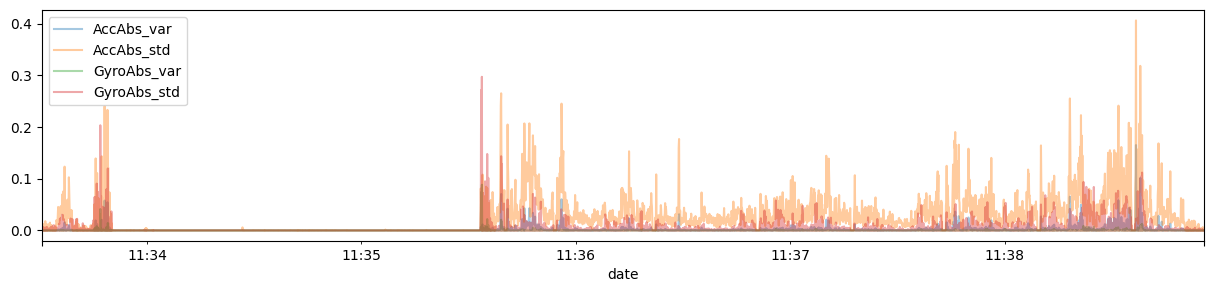

In [79]:
df.plot(alpha = 0.4, figsize = (15,3))

#### Creating Training Data

In [ ]:
window = 256
stride = window//2

In [ ]:
import numpy as np
def window_stack(a, stepsize=stride, width=window):
    n = a.shape[0]
    return np.hstack( a[i:1+n+i-width:stepsize] for i in range(0,width) )

In [ ]:
arr = window_stack(final.to_numpy(), width=window,stepsize=stride)

In [ ]:
np.lib.stride_tricks.as_strided(a, shape=(window,a.shape[1]), strides=(8,4))

In [ ]:
arr = final.to_numpy()
arr.shape

In [ ]:
111409

In [ ]:
import pandas as pd

In [ ]:
pd.rollin

### Analyzing JSON

In [1]:
import matplotlib.pyplot as plt
import json
import os

In [14]:
with open('KeyFrameDensityData_1.json','r') as f:
    js = json.load(f)
X = [i['Position']['X'] for i in js[0]['data']['SpatialData']['DataPoints']]
Y = [i['Position']['Y'] for i in js[0]['data']['SpatialData']['DataPoints']]
Z = [i['Position']['Z'] for i in js[0]['data']['SpatialData']['DataPoints']]
t = [i['DeltaTime'] for i in js[0]['data']['SpatialData']['DataPoints']]
df = pd.DataFrame({"time": t ,"x" : X, "y" : Y, "z" : Z})
df['time'] = df['time'].cumsum()

In [15]:
df

,time,x,y,z
0,12.182931,0.098998,1.308312,-0.919175
1,12.616250,0.085207,1.249220,-0.838226
2,12.916199,0.143881,1.233740,-0.833066
3,13.416234,0.206131,1.210063,-0.870177
4,13.549573,0.298364,1.223344,-0.911234
5,13.749511,0.319169,1.218611,-0.899442
6,13.916187,0.346192,1.225190,-0.897951
7,14.049498,0.350728,1.189728,-0.888368
8,14.249487,0.340668,1.158548,-0.896254
9,14.582829,0.326391,1.150213,-0.913624


In [16]:
pd.DataFrame(np.repeat(df.values, [i for i in range(1, df.shape[0] + 1)], axis=0))

,0,1,2,3
0,12.182931,0.098998,1.308312,-0.919175
1,12.616250,0.085207,1.249220,-0.838226
2,12.616250,0.085207,1.249220,-0.838226
3,12.916199,0.143881,1.233740,-0.833066
4,12.916199,0.143881,1.233740,-0.833066
...,...,...,...,...
1171,38.748630,0.149036,1.495540,-0.660934
1172,38.748630,0.149036,1.495540,-0.660934
1173,38.748630,0.149036,1.495540,-0.660934
1174,38.748630,0.149036,1.495540,-0.660934


In [4]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd
%matplotlib qt



def update_graph(num):
    data=df[df['time']==num]
    graph.set_data (data.x, data.y)
    graph.set_3d_properties(data.z)
    title.set_text('3D Test, time={}'.format(num))
    return title, graph, 


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('3D Test')

data=df[df['time']!=0]
graph, = ax.plot(data.x, data.y, data.z, linestyle="", marker="o")

ani = matplotlib.animation.FuncAnimation(fig, update_graph, 19, 
                               interval=40, blit=True)

plt.show()

In [24]:
data = pd.DataFrame(np.repeat(df.values, [i for i in range(1, df.shape[0] + 1)], axis=0), columns = ['time','X','Y','Z'])
data['grp'] = [i for i in range(1,df.shape[0]+1) for j in range( i )]

In [25]:
data

,time,X,Y,Z,grp
0,12.182931,0.098998,1.308312,-0.919175,1
1,12.616250,0.085207,1.249220,-0.838226,2
2,12.616250,0.085207,1.249220,-0.838226,2
3,12.916199,0.143881,1.233740,-0.833066,3
4,12.916199,0.143881,1.233740,-0.833066,3
...,...,...,...,...,...
1171,38.748630,0.149036,1.495540,-0.660934,48
1172,38.748630,0.149036,1.495540,-0.660934,48
1173,38.748630,0.149036,1.495540,-0.660934,48
1174,38.748630,0.149036,1.495540,-0.660934,48


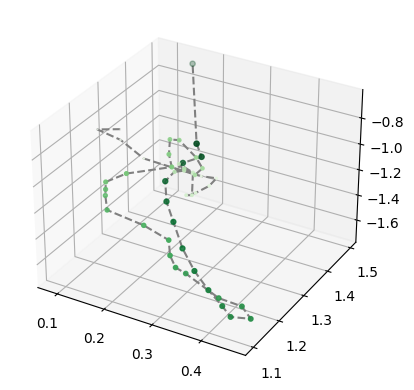

In [5]:
# Data for three-dimensional scattered points
ax = plt.axes(projection='3d')
ax.scatter3D(X, Y, Z, 
                s=[0.3*i for i in range(1,49)],
                c=[0.7*i for i in range(1,49)],
                cmap='Greens');
ax.plot3D(X, Y, Z, 'gray', linestyle='--')


In [6]:
a = np.random.rand(2000, 3)*10
t = np.array([np.ones(100)*i for i in range(20)]).flatten()
df = pd.DataFrame({"time": t ,"x" : a[:,0], "y" : a[:,1], "z" : a[:,2]})

In [7]:
df

,time,x,y,z
0,0.0,9.781245,2.242229,9.854996
1,0.0,3.498352,6.718934,8.444743
2,0.0,6.378617,2.146647,4.165051
3,0.0,7.182116,0.196138,2.164399
4,0.0,4.775268,2.058027,3.465970
...,...,...,...,...
1995,19.0,2.197177,3.009842,0.119217
1996,19.0,7.308514,0.745641,8.563885
1997,19.0,8.681806,5.694893,5.957130
1998,19.0,0.637293,0.735525,1.150208
